# Predict
Make sure to use theano backend for this
Modify your ~/.keras/keras.json to change the backend to "theano"

In [2]:
FN = 'predict'

if your GPU is busy you can use CPU for predictions

In [3]:
import os
os.environ['THEANO_FLAGS'] = 'device=cpu,floatX=float32'

In [4]:
import theano
DEBUG = False
if DEBUG:
    import warnings
    warnings.filterwarnings('ignore','.*Warning, Cannot compute test value')
    warnings.filterwarnings('ignore','.*has no test value')
#     theano.config.optimizer='fast_compile'
#     theano.config.exception_verbosity='high'
    theano.config.optimizer='None'
    theano.config.compute_test_value = 'warn'

In [5]:
import keras
keras.__version__

'2.1.6'

Generate headlines using the "simple" model from http://arxiv.org/pdf/1512.01712v1.pdf

Use indexing of tokens from [vocabulary-embedding](./vocabulary-embedding.ipynb) this does not clip the indexes of the words to `vocab_size`.

Use the index of outside words to replace them with several `oov` words (`oov` , `oov0`, `oov`...) that appear in the same description and headline. This will allow headline generator to replace the oov with the same word in the description

In [6]:
FN0 = 'all-the-news-50000-vocab-embedding'

we will generate predictions using the model generated in this notebook

In [7]:
FN1 = 'train-50000'

input data (`X`) is made from `maxlend` description words followed by `eos`
followed by headline words followed by `eos`
if description is shorter than `maxlend` it will be left padded with `empty`
if entire data is longer than `maxlen` it will be clipped and if it is shorter it will be padded.

labels (`Y`) are the headline words followed by `eos` and clipped or padded to `maxlenh`

In other words the input is made from a `maxlend` half in which the description is padded from the left
and a `maxlenh` half in which `eos` is followed by a headline followed by another `eos` if there is enough space.

The labels match only the second half and 
the first label matches the `eos` at the start of the second half (following the description in the first half)

the model parameters should be identical with what used in training but notice that `maxlend` is flexible

In [8]:
maxlend = 50 # 0 - if we dont want to use description at all
maxlenh = 25
maxlen = maxlend + maxlenh
rnn_size = 512
# rnn_layers = 3  # match FN1
rnn_layers = 2
batch_norm = False

the out of the first `activation_rnn_size` nodes from the top layer will be used for activation and the rest will be used to select predicted word

In [9]:
activation_rnn_size = 40 if maxlend else 0

In [10]:
# training parameters
seed = 42
p_W, p_U, p_dense, weight_decay = 0, 0, 0, 0
optimizer = 'rmsprop'
batch_size=64

In [11]:
# nb_train_samples = 30000
# nb_val_samples = 3000
nb_train_samples = 50000
nb_val_samples = 5000

# read word embedding

In [12]:
import pickle

with open('data/%s.pickle'%FN0, 'rb') as fp:
    embedding, idx2word, word2idx, glove_idx2idx = pickle.load(fp)
vocab_size, embedding_size = embedding.shape

In [13]:
nb_unknown_words = 10

In [14]:
print('dimension of embedding space for words',embedding_size)
print('vocabulary size', vocab_size, 'the last %d words can be used as place holders for unknown/oov words'%nb_unknown_words)
print('total number of different words',len(idx2word), len(word2idx))
print('number of words outside vocabulary which we can substitue using glove similarity', len(glove_idx2idx))
print('number of words that will be regarded as unknonw(unk)/out-of-vocabulary(oov)',len(idx2word)-vocab_size-len(glove_idx2idx))

dimension of embedding space for words 100
vocabulary size 40000 the last 10 words can be used as place holders for unknown/oov words
total number of different words 100089 100089
number of words outside vocabulary which we can substitue using glove similarity 40962
number of words that will be regarded as unknonw(unk)/out-of-vocabulary(oov) 19127


In [15]:
for i in range(nb_unknown_words):
    idx2word[vocab_size-1-i] = '<%d>'%i

In [16]:
for i in range(vocab_size-nb_unknown_words, len(idx2word)):
    idx2word[i] = idx2word[i]+'^'

In [17]:
empty = 0
eos = 1
idx2word[empty] = '_'
idx2word[eos] = '~'

In [18]:
import numpy as np
from keras.preprocessing import sequence
from keras.utils import np_utils
import random, sys

In [19]:
def prt(label, x):
    print(label+':'),
    for w in x:
        print(idx2word[w]),
    print

# Model

In [20]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, RepeatVector
from keras.layers.recurrent import LSTM
from keras.layers.embeddings import Embedding
from keras.regularizers import l2
from keras.layers.core import Lambda
import keras.backend as K
K.backend()

'theano'

In [21]:
# seed weight initialization
random.seed(seed)
np.random.seed(seed)

In [22]:
regularizer = l2(weight_decay) if weight_decay else None

## rnn model

start with a stacked LSTM, which is identical to the bottom of the model used in training

In [23]:
rnn_model = Sequential()
if DEBUG:
    print('DEBUG')
    from keras.layers import InputLayer
    model_input = InputLayer(input_shape=(maxlen,))
    rnn_model.add(model_input)
    rnn_model.output.tag.test_value = np.random.randint(vocab_size,size=(batch_size,maxlen)).astype('float32')
rnn_model.add(Embedding(vocab_size, embedding_size,
                        input_length=maxlen,
#                         batch_input_shape=(batch_size,maxlen),
                        embeddings_regularizer=regularizer, weights=[embedding], mask_zero=True,
                        name='embedding_1'))
for i in range(rnn_layers):
    lstm = LSTM(rnn_size, return_sequences=True, # batch_norm=batch_norm,
                kernel_regularizer=regularizer, recurrent_regularizer=regularizer,
                bias_regularizer=regularizer, dropout=p_W, recurrent_dropout=p_U,
                name='lstm_%d'%(i+1)
                  )
    rnn_model.add(lstm)
    rnn_model.add(Dropout(p_dense, name='dropout_%d'%(i+1)))

In [24]:
if DEBUG:
    print(rnn_model.output.tag.test_value.shape)

### load

use the bottom weights from the trained model, and save the top weights for later

In [25]:
rnn_model.load_weights('data/%s.hdf5'%FN1,by_name=True)
rnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 75, 100)           4000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 75, 512)           1255424   
_________________________________________________________________
dropout_1 (Dropout)          (None, 75, 512)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 75, 512)           2099200   
_________________________________________________________________
dropout_2 (Dropout)          (None, 75, 512)           0         
Total params: 7,354,624
Trainable params: 7,354,624
Non-trainable params: 0
_________________________________________________________________


In [26]:
import h5py
with h5py.File('data/%s.hdf5'%FN1, mode='r') as f:
    if 'layer_names' not in f.attrs and 'model_weights' in f:
        f = f['model_weights']
    weights = [np.copy(v) for v in f['time_distributed_1']['time_distributed_1'].values()]

In [27]:
# kernel, bias
weights = np.array([weights[1], weights[0]])
list(map(lambda x: x.shape, weights))

[(944, 40000), (40000,)]

## headline model

A special layer that reduces the input just to its headline part (second half).
For each word in this part it concatenate the output of the previous layer (RNN)
with a weighted average of the outputs of the description part.
In this only the last `rnn_size - activation_rnn_size` are used from each output.
The first `activation_rnn_size` output is used to computer the weights for the averaging.

In [28]:
def simple_context(X, mask, n=activation_rnn_size, maxlend=maxlend, maxlenh=maxlenh):
    desc, head = X[:,:maxlend,:], X[:,maxlend:,:]
    head_activations, head_words = head[:,:,:n], head[:,:,n:]
    desc_activations, desc_words = desc[:,:,:n], desc[:,:,n:]
    
    # RTFM http://deeplearning.net/software/theano/library/tensor/basic.html#theano.tensor.batched_tensordot
    # activation for every head word and every desc word
    activation_energies = K.batch_dot(head_activations, desc_activations, axes=([2],[2]))
    # make sure we dont use description words that are masked out
    activation_energies = activation_energies + -1e20*K.expand_dims(1.-K.cast(mask[:, :maxlend],'float32'),1)
    
    # for every head word compute weights for every desc word
    activation_energies = K.reshape(activation_energies,(-1,maxlend))
    activation_weights = K.softmax(activation_energies)
    activation_weights = K.reshape(activation_weights,(-1,maxlenh,maxlend))

    # for every head word compute weighted average of desc words
    desc_avg_word = K.batch_dot(activation_weights, desc_words, axes=([2],[1]))
    if DEBUG:
        print(desc_avg_word.tag.test_value.shape)
        print(head_words.tag.test_value.shape)
    return K.concatenate((desc_avg_word, head_words))

In [29]:
model = Sequential()
model.add(rnn_model)
model.summary()
if activation_rnn_size:
    model.add(Lambda(simple_context,
                     mask = lambda inputs, mask: mask[:,maxlend:],
                     output_shape = lambda input_shape: (input_shape[0], maxlenh, 2*(rnn_size - activation_rnn_size)),
                     name='simplecontext_1'))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 75, 512)           7354624   
Total params: 7,354,624
Trainable params: 7,354,624
Non-trainable params: 0
_________________________________________________________________


In [30]:
# we are not going to fit so we dont care about loss and optimizer
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

In [31]:
n = 2*(rnn_size - activation_rnn_size)
n

944

perform the top dense of the trained model in numpy so we can play around with exactly how it works

In [32]:
# out very own softmax
def output2probs(output):
    output = np.dot(output, weights[0]) + weights[1]
    output -= output.max()
    output = np.exp(output)
    output /= output.sum()
    return output

In [33]:
def output2probs1(output):
    output0 = np.dot(output[:n//2], weights[0][:n//2,:])
    output1 = np.dot(output[n//2:], weights[0][n//2:,:])
    output = output0 + output1 # + output0 * output1
    output += weights[1]
    output -= output.max()
    output = np.exp(output)
    output /= output.sum()
    return output

# Test

In [34]:
def lpadd(x, maxlend=maxlend, eos=eos):
    """left (pre) pad a description to maxlend and then add eos.
    The eos is the input to predicting the first word in the headline
    """
    assert maxlend >= 0
    if maxlend == 0:
        return [eos]
    n = len(x)
    if n > maxlend:
        x = x[-maxlend:]
        n = maxlend
    return [empty]*(maxlend-n) + x + [eos]

In [35]:
samples = [lpadd([3]*26)]
# pad from right (post) so the first maxlend will be description followed by headline
data = sequence.pad_sequences(samples, maxlen=maxlen, value=empty, padding='post', truncating='post')

In [36]:
np.all(data[:,maxlend] == eos)

True

In [37]:
data.shape,map(len, samples)

((1, 75), <map at 0x1c2b766390>)

In [38]:
probs = model.predict(data, verbose=0, batch_size=1)
probs.shape

(1, 25, 944)

# Sample generation

In [84]:
# variation to https://github.com/ryankiros/skip-thoughts/blob/master/decoding/search.py
def beamsearch(predict, start=[empty]*maxlend + [eos], avoid=None, avoid_score=1,
               k=1, maxsample=maxlen, use_unk=True, oov=vocab_size-1, empty=empty, eos=eos, temperature=1.0):
    """return k samples (beams) and their NLL scores, each sample is a sequence of labels,
    all samples starts with an `empty` label and end with `eos` or truncated to length of `maxsample`.
    You need to supply `predict` which returns the label probability of each sample.
    `use_unk` allow usage of `oov` (out-of-vocabulary) label in samples
    """
    def sample(energy, n, temperature=temperature):
        """sample at most n different elements according to their energy"""
        n = min(n,len(energy))
        prb = np.exp(-np.array(energy) / temperature )
        res = []
        for i in range(n):
            z = np.sum(prb)
            r = np.argmax(np.random.multinomial(1, prb/z, 1))
            res.append(r)
            prb[r] = 0. # make sure we select each element only once
        return res

    dead_samples = []
    dead_scores = []
    live_samples = [list(start)]
    live_scores = [0]

    while live_samples:
        # for every possible live sample calc prob for every possible label 
        probs = predict(live_samples, empty=empty)
        assert vocab_size == probs.shape[1]

        # total score for every sample is sum of -log of word prb
        cand_scores = np.array(live_scores)[:,None] - np.log(probs)
        cand_scores[:,empty] = 1e20
        if not use_unk and oov is not None:
            cand_scores[:,oov] = 1e20
        if avoid:
            for a in avoid:
                for i, s in enumerate(live_samples):
                    n = len(s) - len(start)
                    if n < len(a):
                        # at this point live_sample is before the new word,
                        # which should be avoided, is added
                        cand_scores[i,a[n]] += avoid_score
        live_scores = list(cand_scores.flatten())
        

        # find the best (lowest) scores we have from all possible dead samples and
        # all live samples and all possible new words added
        scores = dead_scores + live_scores
        ranks = sample(scores, k)
        n = len(dead_scores)
        dead_scores = [dead_scores[r] for r in ranks if r < n]
        dead_samples = [dead_samples[r] for r in ranks if r < n]
        
        live_scores = [live_scores[r-n] for r in ranks if r >= n]
        live_samples = [live_samples[(r-n)//vocab_size]+[(r-n)%vocab_size] for r in ranks if r >= n]

        # live samples that should be dead are...
        # even if len(live_samples) == maxsample we dont want it dead because we want one
        # last prediction out of it to reach a headline of maxlenh
        def is_zombie(s):
            return s[-1] == eos or len(s) > maxsample
        
        # add zombies to the dead
        dead_scores += [c for s, c in zip(live_samples, live_scores) if is_zombie(s)]
        dead_samples += [s for s in live_samples if is_zombie(s)]
        
        # remove zombies from the living 
        live_scores = [c for s, c in zip(live_samples, live_scores) if not is_zombie(s)]
        live_samples = [s for s in live_samples if not is_zombie(s)]

    return dead_samples, dead_scores

In [85]:
# !pip install python-Levenshtein

In [86]:
def keras_rnn_predict(samples, empty=empty, model=model, maxlen=maxlen):
    """for every sample, calculate probability for every possible label
    you need to supply your RNN model and maxlen - the length of sequences it can handle
    """
    sample_lengths = list(map(len, samples))
    assert all(l > maxlend for l in sample_lengths)
    assert all(l[maxlend] == eos for l in samples)
    # pad from right (post) so the first maxlend will be description followed by headline
    data = sequence.pad_sequences(samples, maxlen=maxlen, value=empty, padding='post', truncating='post')
    probs = model.predict(data, verbose=0, batch_size=batch_size)
    return np.array([output2probs(prob[sample_length-maxlend-1]) for prob, sample_length in zip(probs, sample_lengths)])

In [87]:
def vocab_fold(xs):
    """convert list of word indexes that may contain words outside vocab_size to words inside.
    If a word is outside, try first to use glove_idx2idx to find a similar word inside.
    If none exist then replace all accurancies of the same unknown word with <0>, <1>, ...
    """
    xs = [x if x < vocab_size-nb_unknown_words else glove_idx2idx.get(x,x) for x in xs]
    # the more popular word is <0> and so on
    outside = sorted([x for x in xs if x >= vocab_size-nb_unknown_words])
    # if there are more than nb_unknown_words oov words then put them all in nb_unknown_words-1
    outside = dict((x,vocab_size-1-min(i, nb_unknown_words-1)) for i, x in enumerate(outside))
    xs = [outside.get(x,x) for x in xs]
    return xs

In [88]:
def vocab_unfold(desc,xs):
    # assume desc is the unfolded version of the start of xs
    unfold = {}
    for i, unfold_idx in enumerate(desc):
        fold_idx = xs[i]
        if fold_idx >= vocab_size-nb_unknown_words:
            unfold[fold_idx] = unfold_idx
    return [unfold.get(x,x) for x in xs]

In [137]:
import sys
import Levenshtein

def gensamples(X=None, X_test=None, Y_test=None, avoid=None, avoid_score=1, skips=2, k=10, batch_size=batch_size, short=True, temperature=1., use_unk=True):
    if X is None or isinstance(X,int):
        if X is None:
            i = random.randint(0,len(X_test)-1)
        else:
            i = X
        print('HEAD %d:'%i,' '.join(idx2word[w] for w in Y_test[i]))
        print('DESC:',' '.join(idx2word[w] for w in X_test[i]))
        sys.stdout.flush()
        x = X_test[i]
    else:
        for w in X.split():
            w = w.rstrip('^')
            if not w in word2idx:
                word2idx[w] = word2idx.get(w, len(word2idx))

        x = [word2idx[w.rstrip('^')] for w in X.split()]
        
    if avoid:
        # avoid is a list of avoids. Each avoid is a string or list of word indicies
        if isinstance(avoid,str) or isinstance(avoid[0], int) or isinstance(avoid[0], np.int64):
            avoid = [avoid]
        avoid = [a.split() if isinstance(a,str) else a for a in avoid]
        avoid = [vocab_fold([w if isinstance(w,int) or isinstance(w,np.int64) else word2idx[w] for w in a])
                 for a in avoid]

    print('HEADS:')
    samples = []
    if maxlend == 0:
        skips = [0]
    else:
        skips = range(min(maxlend,len(x)), max(maxlend,len(x)), abs(maxlend - len(x)) // skips + 1)
    for s in skips:
        start = lpadd(x[:s])
        fold_start = vocab_fold(start)
        sample, score = beamsearch(predict=keras_rnn_predict, start=fold_start, avoid=avoid, avoid_score=avoid_score,
                                   k=k, temperature=temperature, use_unk=use_unk)
        assert all(s[maxlend] == eos for s in sample)
        samples += [(s,start,scr) for s,scr in zip(sample,score)]

    samples.sort(key=lambda x: x[-1])
    codes = []
    for sample, start, score in samples:
        code = ''
        words = []
        sample = vocab_unfold(start, sample)[len(start):]
        for w in sample:
            if w == eos:
                break
            words.append(idx2word[w])
            code += chr(w//(256*256)) + chr((w//256)%256) + chr(w%256)
        if short:
            distance = min([100] + [-Levenshtein.jaro(code,c) for c in codes])
            if distance > -0.6:
                print(score, ' '.join(words))
        #         print '%s (%.2f) %f'%(' '.join(words), score, distance)
        else:
                print(score, ' '.join(words))
        codes.append(code)
    return samples

In [110]:
seed = 8
random.seed(seed)
np.random.seed(seed)

In [111]:
X = "* Billy Joel is looking for a buyer in Sagaponack^ . Now that he and wife Katie Lee Joel are splitting up , the singer is planning to sell the two oceanfront^ properties he bought for her in 2007 . The four-bedroom mansion ( No . 1 ) and smaller beach bungalow^ ( No . 2 ) will be listed with Corcoran 's Biana^ Stepanian^ for a combined $ 35 million . * Richard Bressler^ , the former CFO of Viacom and now a managing"
Y = "Billy Joel Lists in Sagaponack^"

In [112]:
samples = gensamples(X=X, skips=2, batch_size=batch_size, k=10, temperature=1.)

HEADS:
0.0771053284406662 
2.1537605188786983 Breitbart


In [113]:
X = "18 Cake GIFs That 'll Make You Moist"
Y = "Is it 350degF^ in here or is it just me ?"

In [114]:
samples = gensamples(X, skips=2, batch_size=batch_size, k=10, temperature=1.)

HEADS:
54.977447152137756 calling fan meeting with the NBA rest year of ceremony Ceremony
58.35740965604782 replacement doesn t been fails you fall on 69 character will might lead today


In [115]:
X = "President Barack Obama 's re-election campaign is fundraising off of comments on Obama 's birth certificate by Mitt Romney 's son Matt ."

In [116]:
gensamples(X, skips=2, batch_size=batch_size, k=10, temperature=1, use_unk=True, short=False);

HEADS:
24.03169858455658 Tapper Trump Meets with Trump Rally Calls for Meeting Breitbart
25.301349997520447 Manchin I Am a Trump a Secretary of the Breitbart
26.407176554203033 Tapper Trump Meets with Trump Rally Calls for Times Times
26.685801504179835 Manchin I Am a Trump a Secretary of State Secretary Breitbart
26.96447202563286 Manchin I Am a Trump a Secretary of the Breitbart Breitbart
28.639909647405148 Manchin I Am a Trump a Secretary of the Show Breitbart
29.694961369037628 Manchin I Am a Trump a Secretary of State of the Breitbart
30.28140479326248 Tapper Trump Meets with Trump Rally Calls for Meeting with Tim
30.928372845053673 Manchin I Am a Trump a Secretary of State of the Breitbart Breitbart
31.655028466135263 Manchin I Am a Trump a Secretary of State of the Days Breitbart
31.99841856583953 Manchin I Am a Trump a Secretary of State of the Times Breitbart
33.841714791953564 Manchin I Am a Trump a Secretary of State of the Breitbart Breitbart Breitbart
49.261028826236725 Ta

In [117]:
X = "What have you been listening to this year ? If you want to find out using cold , hard evidence , then Spotify 's new Year in Music tool will tell you ."
Y = "Spotify Will Make You Smarter for Your App"

In [118]:
samples = gensamples(X, skips=2, batch_size=batch_size, k=10, temperature=1)

HEADS:
21.469099640846252 Breitbart Clinton Campaign on Breitbart the Trump Breitbart


In [119]:
headline = samples[0][0][len(samples[0][1]):]
print(headline)

[39, 255, 1524, 10, 39, 2, 62, 39, 1]


In [120]:
' '.join(idx2word[w] for w in headline)

'Breitbart Clinton Campaign on Breitbart the Trump Breitbart ~'

In [121]:
avoid = headline

In [138]:
samples = gensamples(X, avoid=avoid, avoid_score=.1, skips=2, batch_size=batch_size, k=10, temperature=1.)

[[39, 255, 1524, 10, 39, 2, 62, 39, 1]]
HEADS:
23.028047561645508 Donald Trump I Will Have a a to the Breitbart


In [139]:
avoid = samples[0][0][len(samples[0][1]):]

In [140]:
samples = gensamples(X, avoid=avoid, avoid_score=.1, skips=2, batch_size=batch_size, k=10, temperature=1.)

[[296, 62, 525, 891, 1324, 3, 3, 4, 2, 39, 1]]
HEADS:
28.8488640666008 Donald Trump Campaign Hillary Clinton on It s to Breitbart Breitbart Breitbart


In [141]:
len(samples)

20

# Weights

In [142]:
def wsimple_context(X, mask, n=activation_rnn_size, maxlend=maxlend, maxlenh=maxlenh):
    desc, head = X[:,:maxlend], X[:,maxlend:]
    head_activations, head_words = head[:,:,:n], head[:,:,n:]
    desc_activations, desc_words = desc[:,:,:n], desc[:,:,n:]
    
    # RTFM http://deeplearning.net/software/theano/library/tensor/basic.html#theano.tensor.batched_tensordot
    # activation for every head word and every desc word
    activation_energies = K.batch_dot(head_activations, desc_activations, axes=([2],[2]))
    # make sure we dont use description words that are masked out
    assert mask.ndim == 2
    activation_energies = K.switch(mask[:, None, :maxlend], activation_energies, -1e20)
    
    # for every head word compute weights for every desc word
    activation_energies = K.reshape(activation_energies,(-1,maxlend))
    activation_weights = K.softmax(activation_energies)
    activation_weights = K.reshape(activation_weights,(-1,maxlenh,maxlend))

    return activation_weights


class WSimpleContext(Lambda):
    def __init__(self):
        super(WSimpleContext, self).__init__(wsimple_context)
        self.supports_masking = True

    def compute_mask(self, input, input_mask=None):
        return input_mask[:, maxlend:]
    
    def get_output_shape_for(self, input_shape):
        nb_samples = input_shape[0]
        n = 2*(rnn_size - activation_rnn_size)
        return (nb_samples, maxlenh, n)

In [143]:
wmodel = Sequential()
wmodel.add(rnn_model)

In [144]:
wmodel.add(Lambda(wsimple_context,
                 mask = lambda inputs, mask: mask[:,maxlend:],
                 output_shape = lambda input_shape: (input_shape[0], maxlenh, maxlend)))

In [145]:
wmodel.compile(loss='categorical_crossentropy', optimizer=optimizer)

## test

In [146]:
seed = 8
random.seed(seed)
np.random.seed(seed)

In [147]:
X = "Representatives of the groups depicted in The Revenant^ spoke with BuzzFeed News about the actor 's Golden Globes speech calling on listeners to `` protect ... indigenous lands . ''"
Y = "Native American Groups Officially Respond To Leonardo DiCaprio 's Call To Action"

In [148]:
samples = gensamples(X, skips=2, batch_size=batch_size, k=10, temperature=1.)

HEADS:
35.29671483486891 Islamic State Blues A Removal of Kim Jong Un Philippines
48.19317126274109 EXCLUSIVE s Mason No Weapons We Have to Speak with Prison


In [149]:
sample = samples[0][0]

In [150]:
' '.join([idx2word[w] for w in sample])

'_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ representatives of the groups depicted in The Revenant spoke with BuzzFeed News about the actor <1>^ Golden Globes speech calling on listeners to <2>^ protect <3>^ indigenous Lands <0>^ <4>^ ~ Islamic State Blues A Removal of Kim Jong Un Philippines ~'

In [151]:
data = sequence.pad_sequences([sample], maxlen=maxlen, value=empty, padding='post', truncating='post')
data.shape

(1, 75)

In [152]:
weights = wmodel.predict(data, verbose=0, batch_size=1)
weights.shape

(1, 25, 50)

In [153]:
startd = np.where(data[0,:] != empty)[0][0]
lenh = np.where(data[0,maxlend+1:] == eos)[0][0]
startd, lenh

(20, 10)

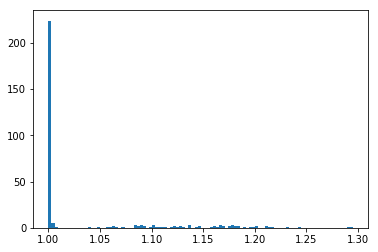

In [154]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(np.array(weights[0,:lenh,startd:].flatten()+1), bins=100);

In [155]:
import numpy as np
from IPython.core.display import display, HTML

def heat(sample,weights,dark=0.3):
    weights = (weights - weights.min())/(weights.max() - weights.min() + 1e-4)
    html = ''
    fmt = ' <span style="background-color: #{0:x}{0:x}ff">{1}</span>'
    for t,w in zip(sample,weights):
        c = int(256*((1.-dark)*(1.-w)+dark))
        html += fmt.format(c,idx2word[t])
    display(HTML(html))

In [156]:
heat(sample, weights[0,-1])

In [157]:
import pandas as pd
import seaborn as sns

In [158]:
columns = [idx2word[data[0,i]] for i in range(startd,maxlend)]
rows = [idx2word[data[0,i]] for i in range(maxlend+1,maxlend+lenh+1)]

In [159]:
df = pd.DataFrame(weights[0,:lenh,startd:],columns=columns,index=rows)

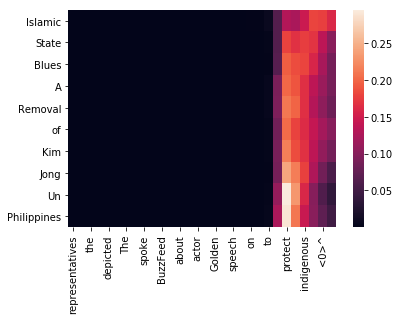

In [160]:
sns.heatmap(df);